In [4]:
from pyparsing import Word,Optional,alphanums,alphas,Literal,OneOrMore,oneOf,Suppress
import pyparsing as p

def groupornot(tokens):
    if len(tokens.asList()) == 1:
        pass
    else:
        return ' '.join(tokens.asList())

word = OneOrMore(p.Word(p.printables, excludeChars='{}[]#\n|')).setParseAction(groupornot)
ele = p.Forward()
items = p.Group(ele) + p.ZeroOrMore('|' + p.Group(ele))
# select = p.Group(p.ZeroOrMore(word) + p.Group(Suppress('{') + items + Suppress('}')))
# option = p.Group(p.ZeroOrMore(word) + p.Group(Suppress('[')+ items + Suppress(']')))

select = p.ZeroOrMore(word) + p.Group(Suppress('{') + items + Suppress('}'))
option = p.ZeroOrMore(word) + p.Group('['+ items + ']')

ele <<= p.OneOrMore(option^select^word)

parser = ele

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import copy
from collections import deque

class Node():
    def __init__(self, isLeaf=False, value=None, color='g'):
        self.isLeaf = isLeaf
        self.value = value
        self.node_id = create_node()
        self.color = color
        G.add_node(self.node_id, isLeaf=self.isLeaf,
                   value=self.value, color=self.color)


def parse(lst, parent):  # 模型输入当前序列"[X,X,X]"的parent节点，输出当前序列所有的叶子节点
    child = deque([])  # 收集当前序列的叶子节点
    if lst[0] == '[':  # 说明当前序列是可选序列，需要建立空节点
        node = Node()
        #parent.next.append(node) # 父节点连接到空节点上
        G.add_edge(parent.node_id, node.node_id)
        child.append([node])  # 指示当前序列是否可选的空节点不能被“遮挡”，所以它一定是叶子节点
        lst = lst[1:-1]  # 将["[",X,X,X,']'] 变为[X,X,X]
    flag = 0  # 1 平行 0 继承

    if len(lst) >= 2 and lst[1] == "|":  # 一个序列不是继承就是并行 ，这里判断是否是并行
        flag = 1
        lst = lst[0:len(lst):2]  # [X,'|',X,"|",X]->[X,X,X]
        # 去掉所有竖线

    if isinstance(lst[0], list):  # 先单独处理序列中第一个X  [X,....]，为了能和后面for循环逻辑对上
        node = Node()
        children = parse(lst[0], node)
        child.append(children)  # X序列的所有叶子节点被收集到child中，child形式 [[X1的孩子]]
    else:
        # 若X不是可以继续解析的序列，代表解析到最后一层，里面的数据有效
        node = Node(isLeaf=True, value=lst[0])
        child.append([node])

    pre = node  # pre

    if len(lst) == 1:  # 若序列只有一个X，需要单独处理 一定是继承的情况
        # parent.next.append(pre)
        G.add_edge(parent.node_id, pre.node_id)
        # 这里if else 同意child的返回形式  [[X1的孩子],[X2的孩子]] -> [X1的孩子，X2的孩子]
        if len(child) == 1:
            return child[0]
        else:
            c = []
            for item in child:
                c.extend(item)
            return c   # return child

    if flag == 0:  # 同样是单独处理序列中的第一个，如果是继承关系，父节点就链下来
        # parent.next.append(pre)
        G.add_edge(parent.node_id, pre.node_id)

    for synax in lst[1:]:
        if isinstance(synax, list):
            node = Node()
            child.append(parse(synax, node))
        else:
            node = Node(isLeaf=True, value=synax)
            child.append([node])
        cur = node  # current
        if flag == 0:  # 继承
            # child [[pre的孩子们]，[cur的孩子们]]
            for item in child.popleft():  # 将pre孩子们的下一个全指向cur，同时弹出pre的孩子们
                # item.next.append(cur)
                G.add_edge(item.node_id, cur.node_id)
            pre = cur  # pre来到下一个位置
        else:  # 平行
            # parent.next.append(pre) #如果是平行，就将父节点依次链接下来就行
            G.add_edge(parent.node_id, pre.node_id)
            pre = cur

    if flag == 1:  # 给for循环 擦屁股
        # parent.next.append(pre)
        G.add_edge(parent.node_id, pre.node_id)
    c = []
    #如果是平行关系 child形式[[x1的孩子们]，[x2的孩子们],[x3的孩子们]....]
    #如果是继承关系 child形式 [[最后一个x的孩子们]]
    for item in child:
        c.extend(item)
    return c


def create_node():
    node = len(list(G.nodes)) + 1
    return node

def all_paths(firstnode, lastnode):
    for path in nx.all_simple_paths(G, firstnode, lastnode):
        origin = [G.nodes[i]['value'] for i in path]
        value_path = []
        for i in origin:
            if i != None:
                value_path.append(i)
        print(value_path[1:-1])

def draw():
    # nx.draw(G, with_labels=True, font_weight='bold', pos=nx.shell_layout(G))
    # plt.show()
    labels = nx.get_node_attributes(G, "value")
    colors = nx.get_node_attributes(G, "color")
    colors = list(colors.values())
    colors[0] = 'r'
    colors[-1] = 'r'
    # pos = nx.random_layout(G, seed=23)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, node_color=colors, width=4, edge_color='#8888ff', arrowsize=20, node_size=800, font_weight='bold', alpha=0.6)
    nx.draw_networkx_labels(G, pos, labels=labels)
#     plt.show()

G = nx.DiGraph()

['t', [[[['a'], '|', ['b'], '|', ['c']]], '|', ['A'], '|', ['B']], 'z', [['q'], '|', ['p'], '|', ['w']], 'end']
['t', 'a', 'z', 'q']
['t', 'a', 'z', 'p']
['t', 'a', 'z', 'w']
['t', 'b', 'z', 'q']
['t', 'b', 'z', 'p']
['t', 'b', 'z', 'w']
['t', 'c', 'z', 'q']
['t', 'c', 'z', 'p']
['t', 'c', 'z', 'w']
['t', 'A', 'z', 'q']
['t', 'A', 'z', 'p']
['t', 'A', 'z', 'w']
['t', 'B', 'z', 'q']
['t', 'B', 'z', 'p']
['t', 'B', 'z', 'w']


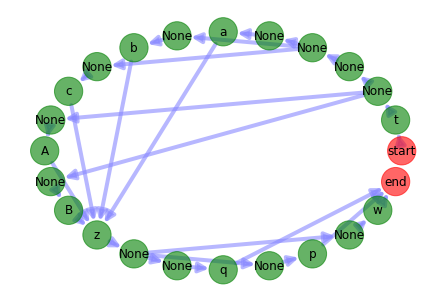

In [6]:
node = Node(value='start')
string0 = '[a][b][c]{A|B|C}'
string1 = 't { {a|b|c} | A | B } z {q|p|w}'
string2 = ' {{a|b|c} | A | B }[z]  {q|p|w}'
lst = parser.parseString(string1).asList()
lst.append('end')
print(lst)
parse(lst, node)
draw()

firstnode = list(G.nodes)[0]
lastnode = list(G.nodes)[-1]
all_paths(firstnode, lastnode)

['t', 'a', 'z', 'q']
['t', 'a', 'z', 'p']
['t', 'a', 'z', 'w']
['t', 'b', 'z', 'q']
['t', 'b', 'z', 'p']
['t', 'b', 'z', 'w']
['t', 'c', 'z', 'q']
['t', 'c', 'z', 'p']
['t', 'c', 'z', 'w']
['t', 'A', 'z', 'q']
['t', 'A', 'z', 'p']
['t', 'A', 'z', 'w']
['t', 'B', 'z', 'q']
['t', 'B', 'z', 'p']
['t', 'B', 'z', 'w']


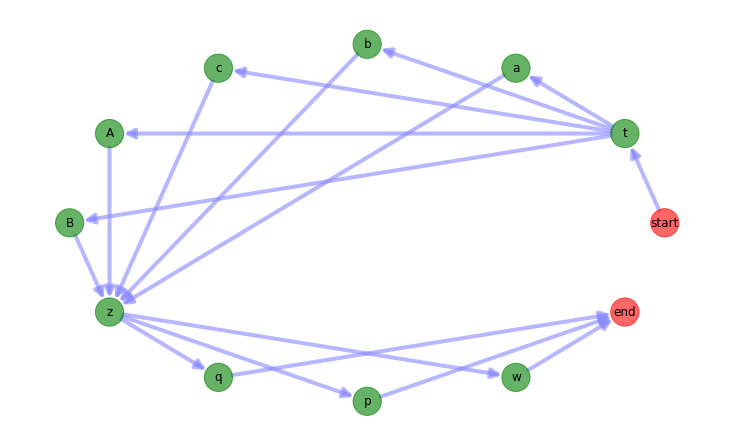

In [7]:
all_nodes = copy.deepcopy(G.nodes)
for node in all_nodes:
    if G.nodes[node]['value'] == None:
        all_pre = list(G.predecessors(node))
        all_suc = list(G.successors(node))
        for pre in all_pre:
            for suc in all_suc:
                G.add_edge(pre, suc)
        G.remove_node(node)

plt.figure(figsize=(10, 6))
draw()

all_paths(firstnode, lastnode)


# 改变布局
# https://blog.csdn.net/m0_37427515/article/details/112728512?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-2-112728512-blog-127349742.pc_relevant_3mothn_strategy_and_data_recovery&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-2-112728512-blog-127349742.pc_relevant_3mothn_strategy_and_data_recovery&utm_relevant_index=5

